In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit, vmap, grad

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from google.colab import files

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Data Reading and Cleaning

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1)
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


# ML modeling

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
def utility(p, y_true, th, a11, a12, a21):

    Ypred = 0.0 * y_true
    Ypred[p > th] = 1.0

    # TP and TN contribution to the utility function
    Tmask = Ypred == y_true
    U_T = np.sum(Tmask)

    # FP contribution to the utility function
    Fmask = ~Tmask
    Pmask = Ypred == 1.0
    U_FP = np.sum(Fmask * Pmask)

    # FN contribution to the utility function
    Nmask = ~Pmask
    U_FN = np.sum(Fmask * Nmask)

    U = (a11 * U_T - a12 * U_FP - a21 * U_FN) / len(p)

    return U

def max_utility(y_true, y_pred):

    threshold_vec = np.linspace(0.0, 1.0, 1001)

    # make utility curve
    u = [utility(y_pred, y_true, th, 1, 0, 0) for th in threshold_vec]

    return np.max(u)

In [ ]:
def NetTrustScore(y_true, p):
    alpha = 1.0
    beta = 1.0

    y_hat = np.where(p >= 0.5, 1, 0)
    A = np.sum(np.power(np.where(y_hat == y_true, p, 0), alpha))
    B = np.sum(np.power(np.where(y_hat != y_true, 1.0 - p, 0), beta))

    return ( A + B ) / y_true.shape[0]

In [ ]:
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features][::]
y = df[dependent_var][::]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=453)

In [ ]:
# Initialize lists to store test statistics for each split
auc_scores = []
accuracy_scores = []
brier_scores = []
NetTrust_score = []
max_utility_scores = []

# Set the number of sims
num_sims = 50

# Initialize classifiers
rf_classifier = RandomForestClassifier(max_depth=3, n_estimators=200)
logreg_classifier = LogisticRegression()
knn_classifier = KNeighborsClassifier(weights = 'distance', n_neighbors=250)
nb_classifier = GaussianNB()

# Perform 20 random splits and evaluate each classifier
for i in range(num_sims):

    print("Iteration %i"%i)

    # Randomly split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45323+i*543)

    # Train the classifiers
    rf_classifier.fit(X_train, y_train)
    logreg_classifier.fit(X_train, y_train)
    knn_classifier.fit(X_train, y_train)
    nb_classifier.fit(X_train, y_train)

    # Make predictions and probability estimates
    rf_proba = rf_classifier.predict_proba(X_test)
    logreg_proba = logreg_classifier.predict_proba(X_test)
    knn_predictions = knn_classifier.predict_proba(X_test)
    nb_proba = nb_classifier.predict_proba(X_test)

    # Calculate test statistics for each classifier
    rf_auc = roc_auc_score(y_test, rf_proba[:, 1])
    rf_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))
    rf_brier_score = brier_score_loss(y_test, rf_proba[:, 1])
    rf_NetTrust_score = NetTrustScore(y_test, rf_proba[:, 1][:, np.newaxis])
    rf_max_u_score = max_utility(y_test, rf_proba[:, 1])

    logreg_auc = roc_auc_score(y_test, logreg_proba[:, 1])
    logreg_accuracy = accuracy_score(y_test, logreg_classifier.predict(X_test))
    logreg_brier_score = brier_score_loss(y_test, logreg_proba[:, 1])
    logreg_NetTrust_score = NetTrustScore(y_test, logreg_proba[:, 1][:, np.newaxis])
    logreg_max_u_score = max_utility(y_test, logreg_proba[:, 1])

    knn_auc = roc_auc_score(y_test, knn_predictions[:, 1])
    knn_accuracy = accuracy_score(y_test, knn_classifier.predict(X_test))
    knn_brier_score = brier_score_loss(y_test, knn_predictions[:, 1])
    knn_NetTrust_score = NetTrustScore(y_test, knn_predictions[:, 1][:, np.newaxis])
    knn_max_u_score = max_utility(y_test, knn_predictions[:, 1])

    nb_auc = roc_auc_score(y_test, nb_proba[:, 1])
    nb_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test))
    nb_brier_score = brier_score_loss(y_test, nb_proba[:, 1])
    nb_NetTrust_score = NetTrustScore(y_test, nb_proba[:, 1][:, np.newaxis])
    nb_max_u_score = max_utility(y_test, nb_proba[:, 1])

    # Append the test statistics to the corresponding lists
    auc_scores.append([rf_auc, logreg_auc, knn_auc, nb_auc])
    accuracy_scores.append([rf_accuracy, logreg_accuracy, knn_accuracy, nb_accuracy])
    brier_scores.append([rf_brier_score, logreg_brier_score, knn_brier_score, nb_brier_score])
    NetTrust_score.append([rf_NetTrust_score, logreg_NetTrust_score, knn_NetTrust_score, nb_NetTrust_score])
    max_utility_scores.append([rf_max_u_score, logreg_max_u_score, knn_max_u_score, nb_max_u_score])

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


In [ ]:
# Calculate the average and variance for each test statistic
auc_avg = np.mean(auc_scores, axis=0)
auc_var = np.std(auc_scores, axis=0)

accuracy_avg = np.mean(accuracy_scores, axis=0)
accuracy_var = np.std(accuracy_scores, axis=0)

brier_avg = np.mean(brier_scores, axis=0)
brier_var = np.std(brier_scores, axis=0)

NetTrust_avg = np.mean(NetTrust_score, axis=0)
NetTrust_var = np.std(NetTrust_score, axis=0)

umax_avg = np.mean(max_utility_scores, axis=0)
umax_var = np.std(max_utility_scores, axis=0)

# Print the results
print(" Measure, RF, LR, knn, NB")
print("AUC - ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$".format(auc_avg[0], auc_var[0], auc_avg[1], auc_var[1], auc_avg[2], auc_var[2], auc_avg[3],  auc_var[3]))
print("Accuracy - ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$".format(accuracy_avg[0], accuracy_var[0], accuracy_avg[1], accuracy_var[1], accuracy_avg[2], accuracy_var[2], accuracy_avg[3],  accuracy_var[3]))
print("Brier - ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$".format(brier_avg[0], brier_var[0], brier_avg[1], brier_var[1], brier_avg[2], brier_var[2], brier_avg[3],  brier_var[3]))
print("NetTrust - ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$".format(NetTrust_avg[0], NetTrust_var[0], NetTrust_avg[1], NetTrust_var[1], NetTrust_avg[2], NetTrust_var[2], NetTrust_avg[3],  NetTrust_var[3]))
print("Max Utility - ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$".format(umax_avg[0], umax_var[0], umax_avg[1], umax_var[1], umax_avg[2], umax_var[2], umax_avg[3],  umax_var[3]))





 Measure, RF, LR, knn, NB
AUC - $0.799 \pm 0.004$ & $0.788 \pm 0.007$ & $0.785 \pm 0.004$ & $0.781 \pm 0.005$
Accuracy - $0.733 \pm 0.004$ & $0.735 \pm 0.007$ & $0.732 \pm 0.004$ & $0.723 \pm 0.004$
Brier - $0.181 \pm 0.001$ & $0.177 \pm 0.003$ & $0.179 \pm 0.002$ & $0.194 \pm 0.003$
NetTrust - $0.581 \pm 0.001$ & $0.593 \pm 0.003$ & $0.600 \pm 0.002$ & $0.602 \pm 0.003$
Max Utility - $0.746 \pm 0.005$ & $0.738 \pm 0.006$ & $0.736 \pm 0.004$ & $0.727 \pm 0.004$


In [ ]:

# Calculate the average and variance for each test statistic
auc_avg = np.mean(auc_scores, axis=0)
auc_var = np.std(auc_scores, axis=0)

accuracy_avg = np.mean(accuracy_scores, axis=0)
accuracy_var = np.std(accuracy_scores, axis=0)

brier_avg = np.mean(brier_scores, axis=0)
brier_var = np.std(brier_scores, axis=0)

# Print the results
print("AUC - Random Forest: {:.4f}, Logistic Regression: {:.4f},  KNN: {:.4f}, Naive Bayes: {:.4f}".format(auc_avg[0], auc_avg[1], auc_avg[2], auc_avg[3]))
print("AUC Std - Random Forest: {:.4f}, Logistic Regression: {:.4f},  KNN: {:.4f}, Naive Bayes: {:.4f}".format(auc_var[0], auc_var[1], auc_var[2], auc_var[3]))

print("Accuracy - Random Forest: {:.4f}, Logistic Regression: {:.4f}, KNN: {:.4f}, Naive Bayes: {:.4f}".format(accuracy_avg[0], accuracy_avg[1], accuracy_avg[2], accuracy_avg[3]))
print("Accuracy Std - Random Forest: {:.4f}, Logistic Regression: {:.4f}, KNN: {:.4f}, Naive Bayes: {:.4f}".format(accuracy_var[0], accuracy_var[1], accuracy_var[2], accuracy_var[3]))

print("Brier Score - Random Forest: {:.4f}, Logistic Regression: {:.4f},  KNN: {:.4f}, Naive Bayes: {:.4f}".format(brier_avg[0], brier_avg[1], brier_avg[2], brier_avg[3]))
print("Brier Score Std - Random Forest: {:.4f}, Logistic Regression: {:.4f}, KNN: {:.4f}, Naive Bayes: {:.4f}".format(brier_var[0], brier_var[1], brier_var[2], brier_var[3]))

AUC - Random Forest: 0.7972, Logistic Regression: 0.7885,  KNN: 0.7846, Naive Bayes: 0.7803
AUC Std - Random Forest: 0.0035, Logistic Regression: 0.0040,  KNN: 0.0034, Naive Bayes: 0.0040
Accuracy - Random Forest: 0.7317, Logistic Regression: 0.7357, KNN: 0.7313, Naive Bayes: 0.7229
Accuracy Std - Random Forest: 0.0045, Logistic Regression: 0.0049, KNN: 0.0035, Naive Bayes: 0.0038
Brier Score - Random Forest: 0.1819, Logistic Regression: 0.1767,  KNN: 0.1796, Naive Bayes: 0.1939
Brier Score Std - Random Forest: 0.0012, Logistic Regression: 0.0019, KNN: 0.0016, Naive Bayes: 0.0029


# Calibration

In [ ]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, rf_proba[:, 1], n_bins=50)
rf_reliability_curve = (fraction_of_positives, mean_predicted_value)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, logreg_proba[:, 1], n_bins=50)
logreg_reliability_curve = (fraction_of_positives, mean_predicted_value)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, knn_predictions[:, 1], n_bins=50)
knn_reliability_curve = (fraction_of_positives, mean_predicted_value)


# Initialize the figure
plt.figure(figsize=(8, 6))

# Plot each reliability curve with a different color
colors = ['steelblue', 'indianred', 'orange', 'm']
classifiers = ['Random Forest', 'Logistic Regression', 'KNN']

for i, (curve, classifier) in enumerate(zip([rf_reliability_curve, logreg_reliability_curve, knn_reliability_curve], classifiers)):
    plt.plot(curve[1], curve[0], lw=4, marker='o', markersize=5, label=classifier, color=colors[i])
    # plt.fill_between(curve[1], curve[0] - curve[0]*0.68, curve[0] + curve[0]*0.68, alpha=0.15, color=colors[i])

# Add reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Set axis labels and title
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')

# Set axis labels and title with updated font size
plt.xlabel('Mean Predicted Probability', fontsize=24)
plt.ylabel('Fraction of Positives', fontsize=24)
plt.title('Calibration Plot', fontsize=24)

# Set legend with updated font size
plt.legend(fontsize=18)

# Set tick labels with updated font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.savefig('calibration-model_comp.pdf', bbox_inches='tight')
files.download('calibration-model_comp.pdf')

# Decision Making Under Non-trivial Cost Function


Now, suppose a non-trivial cost function that changes with the age of the housholder. Let's assume that the reward of TP = TN = 1, and the costs of the FP and FN are as following:


$$ C({\rm FP}) = (1 - {\rm Age} / 100) \times 3 $$

$$ C({\rm FN}) = (1 - {\rm Age} / 100) \times 0.5 $$

Write a function that computes the utility for a given decision threshold of ${\rm th}$. You want to use this equation to estimate the utility function.

$\hat{U} = \frac{1}{n_{\rm test}}\sum_{i=1}^{n_{\rm test}}\left[\mathbb{I}(y_i - \hat{f}_i) \times R(x_i, y_i) - |y_i - \hat{f}_i| \times C(x_i, y_i) \right]$

Finally, compute and reprot the utility of the test sample assuming ${\rm th} = 0.5$ for all three classifiers using the test sample.

In [ ]:
def utility(p, y_true, th, a11, a12, a21):

    Ypred = 0.0 * y_true
    Ypred[p > th] = 1.0

    # TP and TN contribution to the utility function
    Tmask = Ypred == y_true
    U_T = np.sum(Tmask)

    # FP contribution to the utility function
    Fmask = ~Tmask
    Pmask = Ypred == 1.0
    U_FP = np.sum(Fmask * Pmask)

    # FN contribution to the utility function
    Nmask = ~Pmask
    U_FN = np.sum(Fmask * Nmask)

    U = (a11 * U_T - a12 * U_FP - a21 * U_FN) / len(p)

    return U

0.7411631730374024
0.7443485408960131
0.7410604192355117


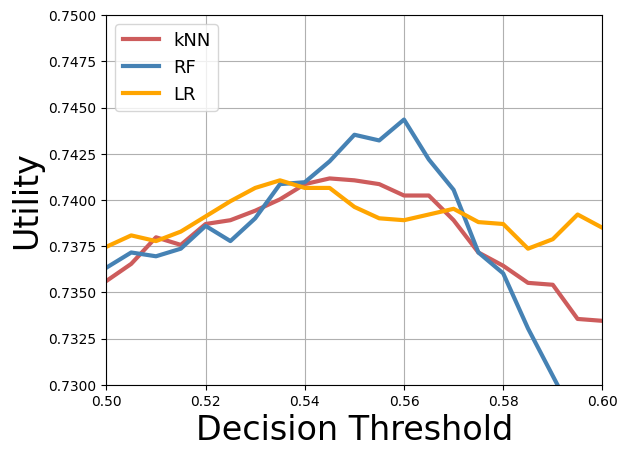

In [ ]:
threshold_vec = np.linspace(0.0, 1.0, 201)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1345)

y_true = y_test.OWNER.to_numpy()

knn_model = KNeighborsClassifier(weights = 'distance', n_neighbors=250)
knn_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth=3, n_estimators=200)
rf_model.fit(X_train, y_train)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test sample
y_pred_knn = knn_model.predict_proba(X_test).T[1]
y_pred_rf = rf_model.predict_proba(X_test).T[1]
y_pred_lr = lr_model.predict_proba(X_test).T[1]

# del knn_model, rf_model, lr_model

# make utility curve
u_knn = [utility(y_pred_knn, y_true, th, 1, 0, 0) for th in threshold_vec]
u_rf = [utility(y_pred_rf, y_true, th, 1, 0, 0) for th in threshold_vec]
u_lr = [utility(y_pred_lr, y_true, th, 1, 0, 0) for th in threshold_vec]

plt.plot(threshold_vec, u_knn, '-', color='indianred', lw=3, label='kNN')
plt.plot(threshold_vec, u_rf, '-', color='steelblue', lw=3, label='RF')
plt.plot(threshold_vec, u_lr, '-', color='orange', lw=3, label='LR')

plt.xlabel('Decision Threshold', size=24)
plt.ylabel('Utility', size=24)

print(np.max(u_knn))
print(np.max(u_rf))
print(np.max(u_lr))

plt.legend(loc=2, prop={'size':13})
plt.xlim(0.50, 0.60)
plt.ylim(0.73, 0.75)
plt.grid()

In [ ]:
def max_utility(X, y, a11, a12, a21, rand_state):

    threshold_vec = np.linspace(0.0, 1.0, 1001)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    y_true = y_test.OWNER.to_numpy()

    rf_model = RandomForestClassifier(max_depth=3, n_estimators=200)
    rf_model.fit(X_train, y_train)

    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the test sample
    y_pred_rf = rf_model.predict_proba(X_test).T[1]
    y_pred_lr = lr_model.predict_proba(X_test).T[1]

    del rf_model, lr_model

    # make utility curve
    u_rf = [utility(y_pred_rf, y_true, th, a11, a12, a21) for th in threshold_vec]
    u_lr = [utility(y_pred_lr, y_true, th, a11, a12, a21) for th in threshold_vec]

    return np.max(u_rf), np.max(u_lr)


print(max_utility(X, y, 1, 0, 0, 1345))
print(max_utility(X, y, 1, 2, 5, 1345))

(0.7476366625565146, 0.7411631730374024)
(0.0690505548705302, 0.06257706535141801)


In [ ]:
F_vec = np.linspace(0.0, 0.2, 11)

n_sims = 20
utility_vec = []

for i in range(n_sims):

    print("Simulation %i"%i)

    # make utility curve
    utility_vec += [np.array([max_utility(X, y, 1.0, F, 0.5*F, 245433 + i * 323) for F in F_vec])]


Simulation 0
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

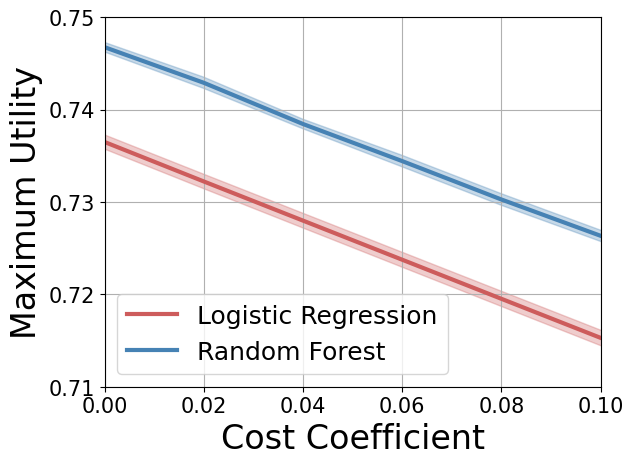

In [ ]:
err = np.std(utility_vec, axis=0).T

mean_utility = np.mean(utility_vec, axis=0).T

plt.plot(F_vec, mean_utility[1], '-', color='indianred', lw=3, label='Logistic Regression')
plt.plot(F_vec, mean_utility[0], '-', color='steelblue', lw=3, label='Random Forest')

#plt.fill_between(F_vec, mean_utility[1] + err[1], mean_utility[1] - err[1], color='grey', alpha=0.3)
#plt.fill_between(F_vec, mean_utility[0] + err[0], mean_utility[0] - err[0], color='grey', alpha=0.3)

plt.fill_between(F_vec, mean_utility[1] + err[1]/np.sqrt(n_sims-1)/2, mean_utility[1] - err[1]/np.sqrt(n_sims-1)/2, color='indianred', alpha=0.3)
plt.fill_between(F_vec, mean_utility[0] + err[0]/np.sqrt(n_sims-1)/2, mean_utility[0] - err[0]/np.sqrt(n_sims-1)/2, color='steelblue', alpha=0.3)

plt.xlabel('Cost Coefficient', size=24)
plt.ylabel('Maximum Utility', size=24)

plt.legend(loc=3, prop={'size': 18})
plt.xlim(0.0, 0.10)
plt.ylim(0.71, 0.75)

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=15)

plt.grid()

plt.savefig('utility-model_comp.pdf', bbox_inches='tight')
files.download('utility-model_comp.pdf')
